# Problem statement


*   The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.
*   Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.

*   There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts. 
*   Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.





# Objective

*   Our goal is to **build a prototype of online hate and abuse comment classifier** which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 




#Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import spacy
import sklearn
import random

import operator
import math
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud



import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import cross_val_score

import joblib

#Importing Training DataSet

In [2]:
from google.colab import files
uploaded=files.upload()

Saving train.csv to train.csv


In [3]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


#Importing Test dataset 

In [4]:
from google.colab import files
uploaded=files.upload()

Saving test.csv to test.csv


In [5]:
import io
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


#Basic Info on the train dataset

In [6]:
#Basic Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
#column names
df_train.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

In [8]:
#datatypes of the Attributes
df_train.dtypes

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

In [9]:
#No of rows and columns
df_train.shape

(159571, 8)

# Finding any Missing Values in both train and test data

In [10]:
#checking for missing value in train dataset
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

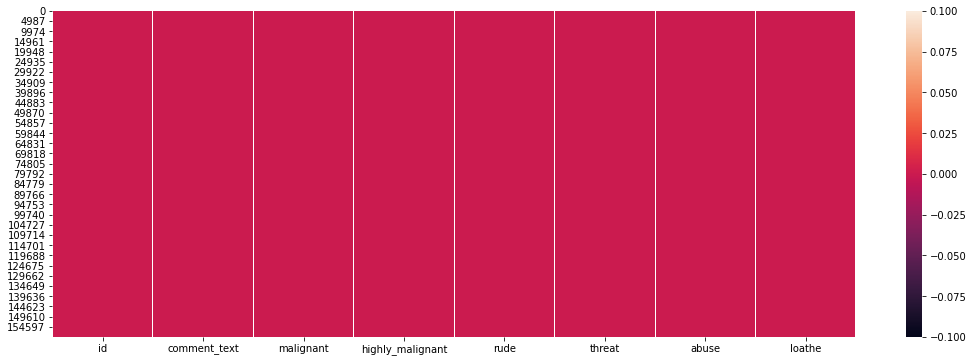

In [11]:
#Graphical Visuvalization of Missing values
plt.figure(figsize=(18,6))
sns.heatmap(df_train.isnull())

In [12]:
#checking for missing value in test dataset
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

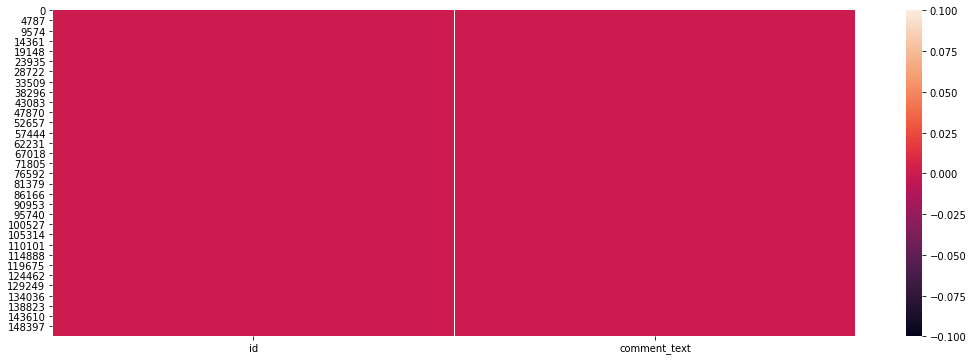

In [13]:
#Graphical Visuvalization of Missing values
plt.figure(figsize=(18,6))
sns.heatmap(df_test.isnull())

#Creating Extra columns for further Observation in train dataset

In [14]:
#creating column to find the total of malignant  
df_train['total'] = df_train.malignant + df_train.highly_malignant + df_train.rude + df_train.threat + df_train.abuse + df_train.loathe

#creating column to find the total length of the Words
df_train['comment_text_length'] = df_train['comment_text'].apply(lambda x: len(x.split()))

#creating column to find the total length of the characters
df_train['comment_caract_len'] = df_train['comment_text'].str.len()

#creating column to find whether comment is malignant or neutral
df_train['type'] = df_train['total'].apply(lambda x: 'Neutral' if x==0 else 'Malignant')

In [15]:
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,264,Neutral
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,112,Neutral
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,233,Neutral
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,622,Neutral
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,67,Neutral
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0,13,65,Neutral
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4,8,44,Malignant
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0,20,115,Neutral
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0,83,472,Neutral
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0,12,70,Neutral


#EDA for train dataset

Analytical Exploration on Labels

In [16]:
#Column type
df_train.groupby('type').size()



type
Malignant     16225
Neutral      143346
dtype: int64

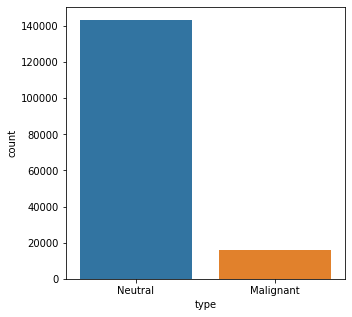

In [17]:
#Visualization
plt.figure(figsize=(5,5))
sns.countplot(df_train["type"])

In [18]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=df_train.iloc[:,2:-4].sum()
data_count

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

Text(0.5, 0, 'Type ')

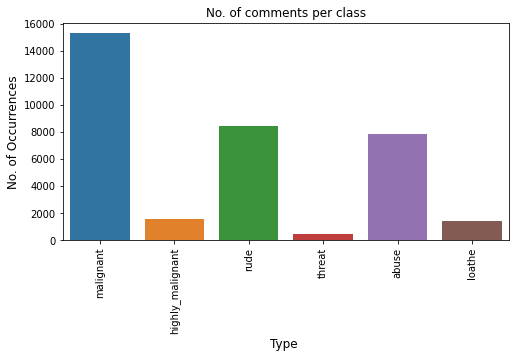

In [19]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values)
plt.xticks(rotation='vertical')
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

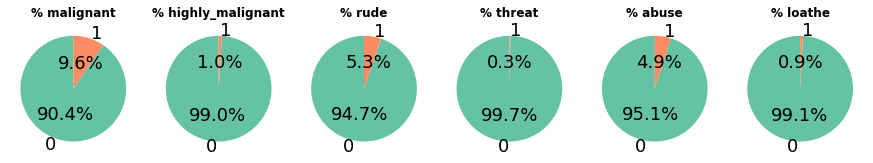

In [20]:
sns.set_palette("Set2")

labels = ['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
labels_setup = ['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
plt.rcParams['font.size'] = 24

plt.figure(figsize=(18, 7))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
for i in range(1, 7):
    plt.subplot(1, 7, i)
    plt.pie(df_train[labels[i-1]].value_counts(), labels=df_train[labels[i-1]].unique(), shadow=False, autopct='%1.1f%%', startangle=90, pctdistance=0.5, textprops={'fontsize': 18})
    title = '% ' + str(labels[i-1])
    plt.title(title, fontweight="bold", size=12)

#Analytical Exploration on comment_text

**Analysis on comment_text(Number of words)**

In [21]:
without_malignant = df_train[df_train.total == 0]['comment_text'].apply(lambda x: len(x.split()))
with_malignant = df_train[df_train.total >= 1]['comment_text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Comment_text length in terms of word count')

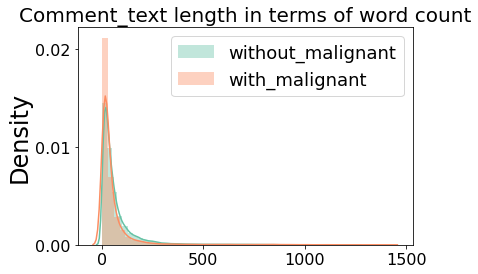

In [22]:
sns.distplot(without_malignant, label='without_malignant')
sns.distplot(with_malignant, label='with_malignant')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Comment_text length in terms of word count", fontsize=20)

### Analysis on comment_text(Number of characters)

In [23]:
without_malignant = df_train[df_train.total == 0]['comment_caract_len']
with_malignant = df_train[df_train.total >= 1]['comment_caract_len']

Text(0.5, 1.0, 'Commentary length analysis (number of characters)')

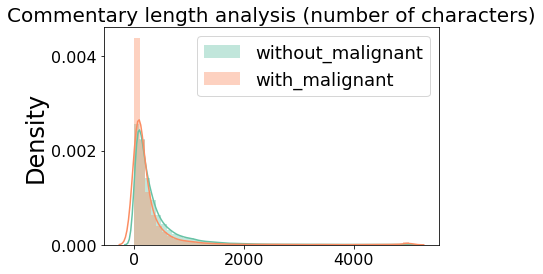

In [24]:
sns.distplot(without_malignant, label='without_malignant')
sns.distplot(with_malignant, label='with_malignant')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Commentary length analysis (number of characters)", fontsize=20)

# Feature Engineering
- Before moving further in this section first let's find the correlation between the features using Heatmap.

In [25]:
#correlation
cor=df_train.corr()
cor


,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,0.869050,-0.052441,-0.054413
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.517967,0.008453,0.010175
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,0.879731,-0.042205,-0.042910
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,0.251314,-0.006688,-0.007917
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,0.869177,-0.043639,-0.045027
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,0.448341,-0.014493,-0.013628
total,0.869050,0.517967,0.879731,0.251314,0.869177,0.448341,1.000000,-0.047070,-0.048211
comment_text_length,-0.052441,0.008453,-0.042205,-0.006688,-0.043639,-0.014493,-0.047070,1.000000,0.987793
comment_caract_len,-0.054413,0.010175,-0.042910,-0.007917,-0.045027,-0.013628,-0.048211,0.987793,1.000000


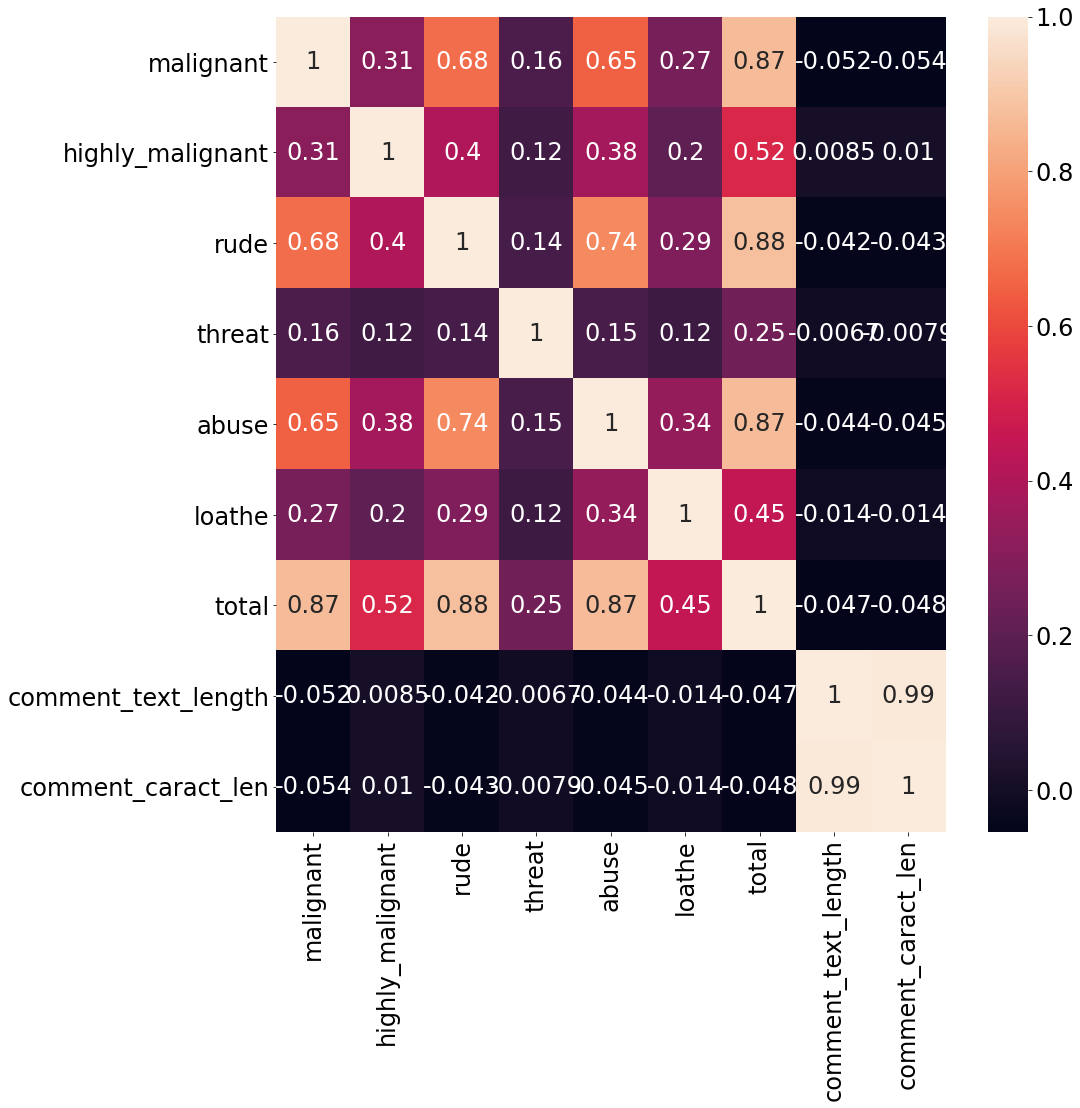

In [26]:
#Visualization of Correlation
#usind Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
sns.heatmap((cor),annot=True)


###Observation on correlation b/w labels
- apparent correlation between malignant, rude and abuse

#Preprocess the Comment_text column

#### Merge the test and train data to vectorize the value in equal length inorder to avoid value error

**Eg:** Value error : X has 2 features per sample; expecting 157093

In [27]:
#defining values for train and test comment_text column
df1=df_train['comment_text']
df2=df_test['comment_text']
print(df1.shape,df2.shape)

(159571,) (153164,)


In [28]:
#appending both train and test data
df=df1.append(df2,ignore_index=True)
print(df.shape)
df

(312735,)


0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
312730    . \n i totally agree, this stuff is nothing bu...
312731    == Throw from out field to home plate. == \n\n...
312732    " \n\n == Okinotorishima categories == \n\n I ...
312733    " \n\n == ""One of the founding nations of the...
312734    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 312735, dtype: object

**First lets see how the comments look like**

In [29]:
df[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [30]:
df[100000]

"I think she meets Notability guidelines and thanks for creating the page for her. She was a big icon in the pageant drag community and in the drag/gay community in general. Her death has been covered by several 'mainstream' media outlets."

**Observation**

*   The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further down the pipeline.




###Preprocessing
Preprocessing involved the following steps

1. Removing Punctuations and other special characters
2. Splitting the comments into individual words
3. Removing Stop Words
4. Lemmatising
5. Applying Count Vectoriser
6. Splitting dataset into Training and Testing



In [31]:
#Converting all the characters in the reviews to lowercase
df_clean = df.str.lower()
df_clean[1]

"d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)"

In [32]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ',x)

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r'', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df_clean = df_clean.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

df_clean[100000]

'i think she meets notability guidelines and thanks for creating the page for her  she was a big icon in the pageant drag community and in the drag gay community in general  her death has been covered by several  mainstream  media outlets '

In [33]:
df_clean

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
312730        i totally agree  this stuff is nothing but...
312731       throw from out field to home plate        d...
312732            okinotorishima categories       i see ...
312733              one of the founding nations of the e...
312734           stop already  your bullshit is not welc...
Name: comment_text, Length: 312735, dtype: object

In [34]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
#Remove all the stopwords
stop_words = set(stopwords.words('english') + ['ur','im','doin','ure','i','so','t'])
df_clean = df_clean.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

#Lemmetizing
WL = WordNetLemmatizer()
df_clean = df_clean.apply(lambda x: ' '.join(WL.lemmatize(i) for i in x.split()))
df_clean.head(5)

0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
Name: comment_text, dtype: object

#Seperating the preprocessed train and test data

In [36]:
clean_train=df_clean[0:159571]
clean_test=df_clean[159571:]

In [37]:
df_train["clean_text"]=clean_train
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,264,Neutral,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,112,Neutral,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,233,Neutral,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,622,Neutral,make real suggestion improvement wondered sect...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,67,Neutral,sir hero chance remember page


In [38]:
#creating column to find the total length of the cleaned Words
df_train['clean_comment_text_length'] = clean_train.apply(lambda x: len(x.split()))

#creating column to find the total length of the cleaned characters
df_train['clean_comment_caract_len'] = clean_train.str.len()

In [39]:
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type,clean_text,clean_comment_text_length,clean_comment_caract_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,264,Neutral,explanation edits made username hardcore metal...,23,156
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,112,Neutral,aww match background colour seemingly stuck th...,10,67
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,233,Neutral,hey man really trying edit war guy constantly ...,21,141
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,622,Neutral,make real suggestion improvement wondered sect...,52,364
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,67,Neutral,sir hero chance remember page,5,29


In [40]:
print('Original Length of text', df_train.comment_text_length.sum())
print('Clean Length of text', df_train.clean_comment_text_length.sum())
print('Original Length of character', df_train.comment_caract_len.sum())
print('Clean Length of character', df_train.clean_comment_caract_len.sum())

Original Length of text 10734743
Clean Length of text 5499269
Original Length of character 62893130
Clean Length of character 38666751


In [41]:
df_clean

0         explanation edits made username hardcore metal...
1         aww match background colour seemingly stuck th...
2         hey man really trying edit war guy constantly ...
3         make real suggestion improvement wondered sect...
4                             sir hero chance remember page
                                ...                        
312730                totally agree stuff nothing long crap
312731    throw field home plate get faster throwing cut...
312732    okinotorishima category see change agree corre...
312733    one founding nation eu germany law return quit...
312734    stop already bullshit welcome fool think kind ...
Name: comment_text, Length: 312735, dtype: object

#Vectorization

**TFIDF vectorizer**

   We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.



**ngram**

gram_range values: (1,1) for unigram

In [42]:
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x=vectorizer.fit_transform(df_clean)

In [43]:
#seperating the vectorized train and test data
X1=x[0:159571]#vectorized train data
X2=x[159571:]#vectorized test data

In [44]:
X1.shape

(159571, 271969)

In [45]:
X2.shape

(153164, 271969)

#Seperating Our DataSet into 6 sections

we seperate our dataset into 6 section

* id,comment_text,malignant
* id,comment_text,highly_malignant
* id,comment_text,rude
* id,comment_text,threat
* id,comment_text,abuse
* id,comment_text,loathe

In [46]:
df_train_malignant = df_train.loc[:,['id','clean_text','malignant']]
df_train_hmalignant = df_train.loc[:,['id','clean_text','highly_malignant']]
df_train_rude = df_train.loc[:,['id','clean_text','rude']]
df_train_threat = df_train.loc[:,['id','clean_text','threat']]
df_train_abuse = df_train.loc[:,['id','clean_text','abuse']]
df_train_loathe = df_train.loc[:,['id','clean_text','loathe']]

#Importing Relevant Libraries

In [54]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
# Import ML algos
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
bnb = BernoulliNB()
mnb = MultinomialNB()
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100, random_state=42)


#**Benchmarking Define function for prediction**

**Machine Learning Algorithms**
1.   LogisticRegression
2.   KNeighborsClassifier
3.   MultinomialNB
4.   BernoulliNB
5.   LinearSVC
6.   RandomForestClassifier



In [58]:
def cv_tf_train_test(df,label):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    x = X1
    y = df[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        
    # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    #initializing all models
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    print("Lr fit done")
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    print("KN fit done")

    bnb = BernoulliNB()
    bnb.fit(x_train, y_train)
    print("BNB fit done")
        
    mnb = MultinomialNB()
    mnb.fit(x_train, y_train)
    print("MNB fit done")
        
    svm_model = LinearSVC()
    svm_model.fit(x_train, y_train)
    print("SVC fit done")

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(x_train, y_train)
    print("RF fit done")
        
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score of {}'.format(label):[f1_score(lr.predict(x_test), y_test), f1_score(knn.predict(x_test), y_test), 
                                f1_score(bnb.predict(x_test), y_test), f1_score(mnb.predict(x_test), y_test),
                                f1_score(svm_model.predict(x_test), y_test), f1_score(randomforest.predict(x_test), y_test)]} 
   
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])
    
    return df_f1

In [59]:
df_malignant_cv=cv_tf_train_test(df_train_malignant, 'malignant')
df_malignant_cv


Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of malignant
Log Regression,0.709547
KNN,0.230828
BernoulliNB,0.216144
MultinomialNB,0.204737
SVM,0.762282
Random Forest,0.666013


In [61]:
df_hmalignant_cv=cv_tf_train_test(df_train_hmalignant, 'highly_malignant')
df_hmalignant_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of highly_malignant
Log Regression,0.331839
KNN,0.154905
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.356546
Random Forest,0.088725


In [62]:
df_rude_cv=cv_tf_train_test(df_train_rude, 'rude')
df_rude_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of rude
Log Regression,0.720057
KNN,0.255418
BernoulliNB,0.044278
MultinomialNB,0.110701
SVM,0.774566
Random Forest,0.702532


In [63]:
df_threat_cv=cv_tf_train_test(df_train_threat, 'threat')
df_threat_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of threat
Log Regression,0.222222
KNN,0.131579
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.342246
Random Forest,0.081081


In [64]:
df_abuse_cv=cv_tf_train_test(df_train_abuse, 'abuse')
df_abuse_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of abuse
Log Regression,0.599197
KNN,0.227920
BernoulliNB,0.026710
MultinomialNB,0.033689
SVM,0.644455
Random Forest,0.553287


In [65]:
df_loathe_cv=cv_tf_train_test(df_train_loathe, 'loathe')
df_loathe_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of loathe
Log Regression,0.219608
KNN,0.112069
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.328622
Random Forest,0.091703


In [66]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_malignant_cv, df_hmalignant_cv, df_rude_cv, df_threat_cv, df_abuse_cv, df_loathe_cv], axis=1)
f1_all

,F1 Score of malignant,F1 Score of highly_malignant,F1 Score of rude,F1 Score of threat,F1 Score of abuse,F1 Score of loathe
Log Regression,0.709547,0.331839,0.720057,0.222222,0.599197,0.219608
KNN,0.230828,0.154905,0.255418,0.131579,0.227920,0.112069
BernoulliNB,0.216144,0.000000,0.044278,0.000000,0.026710,0.000000
MultinomialNB,0.204737,0.000000,0.110701,0.000000,0.033689,0.000000
SVM,0.762282,0.356546,0.774566,0.342246,0.644455,0.328622
Random Forest,0.666013,0.088725,0.702532,0.081081,0.553287,0.091703


In [67]:
#Transpose the combined F1 dataframe to make it suitable for presentation on a graph
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score of malignant,0.709547,0.230828,0.216144,0.204737,0.762282,0.666013
F1 Score of highly_malignant,0.331839,0.154905,0.000000,0.000000,0.356546,0.088725
F1 Score of rude,0.720057,0.255418,0.044278,0.110701,0.774566,0.702532
F1 Score of threat,0.222222,0.131579,0.000000,0.000000,0.342246,0.081081
F1 Score of abuse,0.599197,0.227920,0.026710,0.033689,0.644455,0.553287
F1 Score of loathe,0.219608,0.112069,0.000000,0.000000,0.328622,0.091703


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

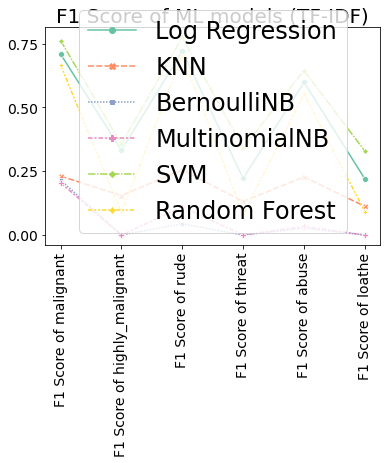

In [68]:
#Lineplot to see the F1 score
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

OBSERVATION

*   from the F1 score board and the line graph we see LinearSVC and Logistic regression models perform best **(Green and blue lines seem to be the highest)**.

*    so we go with **LinearSVC as our final model**  




#Finding the training and testing score for our final model LinearSVC

In [76]:
def cv_tf_train_final(label):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    x = X1
    y = df_train[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

                  
    svm_model = LinearSVC(random_state=6,C=1.0,loss='squared_hinge',penalty='l2',max_iter=8)
    svm.fit(x_train, y_train)
    pred_train=svm.predict(x_train)
    pred_test=svm.predict(x_test)
    print("the score of {} is".format(label))
    print("training accuracy score  :",accuracy_score(y_train,pred_train)*100)
    print("testing accuracy score  :",accuracy_score(y_test,pred_test)*100)
    
    print("*********************************************************************")
    print("\n\n")

In [77]:
malignant=cv_tf_train_final('malignant')
print(malignant)
high_malignant=cv_tf_train_final('highly_malignant')
print(high_malignant)
rude=cv_tf_train_final('rude')
print(rude)
threat=cv_tf_train_final('threat')
print(threat)
abuse=cv_tf_train_final('abuse')
print(abuse)
loathe=cv_tf_train_final('loathe')
print(loathe)


the score of malignant is
training accuracy score  : 98.53266367648772
testing accuracy score  : 95.98930481283422
*********************************************************************



None
the score of highly_malignant is
training accuracy score  : 99.6087699979409
testing accuracy score  : 99.03283756684492
*********************************************************************



None
the score of rude is
training accuracy score  : 99.33213368069545
testing accuracy score  : 97.85678475935828
*********************************************************************



None
the score of threat is
training accuracy score  : 99.93375052596711
testing accuracy score  : 99.7430648395722
*********************************************************************



None
the score of abuse is
training accuracy score  : 98.99730525788056
testing accuracy score  : 97.05673462566845
*********************************************************************



None
the score of loathe is
training accuracy s

# Sample Prediction

In [71]:
X = X1
y = df_train_malignant['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
svm = LinearSVC(random_state=6,C=1.0,loss='squared_hinge',penalty='l2',max_iter=8)
svm.fit(X_train_fit, y_train)
svm.predict(X_test_fit)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
#Sample comments
comment1 = ['You piece of shit']#a Malignant sentence
comment2 = ['What is up garden apple doing']# a normal sentence

In [75]:
#sample prediction on comment1
comment1_vect = tfv.transform(comment1)
svm.predict(comment1_vect)

array([1], dtype=int64)

In [73]:
#sample prediction on comment2
comment2_vect = tfv.transform(comment2)
svm.predict(comment2_vect)

array([0], dtype=int64)

#Observation

1.   The comment 1 is a malignant word and the prediction shows 1 which means the comment is malignant and the prediction is correct
2.   The comment 2 is an ordinary word and the prediction shows 0 which means the comment is not malignant and the prediction is correct

this shows our svm model prediction is good 



#Saving the model

In [91]:
import pickle
def pickle_model(label):
    
    # Split the data into X and y data sets
    x = X1
    y = df_train[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

                  
    svm_model = LinearSVC(random_state=6,C=1.0,loss='squared_hinge',penalty='l2',max_iter=8)
    svm.fit(x_train, y_train)

    # Create a new pickle file based on svm model
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(svm, f)
    

In [92]:
pickle_model('malignant')
pickle_model('highly_malignant')
pickle_model('rude')
pickle_model('threat')
pickle_model('abuse')
pickle_model('loathe')

In [93]:
from google.colab import files
files.download('malignant_model.pkl')
files.download('highly_malignant_model.pkl')
files.download('rude_model.pkl')
files.download('threat_model.pkl')
files.download('abuse_model.pkl')
files.download('loathe_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#USING TEST DATA FOR PREDICTION

# 1.Prediction over test data on label "Malignant"

In [102]:
#fitting Malignant LinearSVC model
fitted_model_malignant=pickle.load(open("malignant_model.pkl","rb"))
fitted_model_malignant

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [103]:
# Predicting Malignant with test data
prediction_malignant=fitted_model.predict(X2)
prediction_malignant

array([0, 0, 0, ..., 0, 0, 0])

# 2.Prediction over test data on label "Highly_Malignant"

In [104]:
#fitting Highly Malignant LinearSVC model
fitted_model_hmalignant=pickle.load(open("highly_malignant_model.pkl","rb"))
fitted_model_hmalignant

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [105]:
# Predicting Highly Malignant with test data
prediction_hmalignant=fitted_model_hmalignant.predict(X2)
prediction_hmalignant

array([0, 0, 0, ..., 0, 0, 0])

# 3.Prediction over test data on label "rude"

In [106]:
#fitting rude LinearSVC model
fitted_model_rude=pickle.load(open("rude_model.pkl","rb"))
fitted_model_rude

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [107]:
# Predicting rude with test data
prediction_rude=fitted_model_rude.predict(X2)
prediction_rude

array([1, 0, 0, ..., 0, 0, 1])

# 4.Prediction over test data on label "threat"

In [108]:
#fitting threat LinearSVC model
fitted_model_threat=pickle.load(open("threat_model.pkl","rb"))
fitted_model_threat

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [109]:
# Predicting threat with test data
prediction_threat=fitted_model_threat.predict(X2)
prediction_threat

array([0, 0, 0, ..., 0, 0, 0])

# 5.Prediction over test data on label "abuse"

In [110]:
#fitting abuse LinearSVC model
fitted_model_abuse=pickle.load(open("abuse_model.pkl","rb"))
fitted_model_abuse

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [111]:
# Predicting abuse with test data
prediction_abuse=fitted_model_abuse.predict(X2)
prediction_abuse

array([1, 0, 0, ..., 0, 0, 0])

# 6.Prediction over test data on label "loathe"

In [112]:
#fitting loathe LinearSVC model
fitted_model_loathe=pickle.load(open("loathe_model.pkl","rb"))
fitted_model_loathe

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8,
          multi_class='ovr', penalty='l2', random_state=6, tol=0.0001,
          verbose=0)

In [113]:
# Predicting loath with test data
prediction_loathe=fitted_model_loathe.predict(X2)
prediction_loathe

array([0, 0, 0, ..., 0, 0, 0])

#Predicted output using test data

In [116]:
malignant_test=pd.DataFrame({"comment_text":df_test["comment_text"],"Malignant":prediction_malignant,"highly_malignant":prediction_hmalignant,
                             "threat":prediction_threat,
                             "rude":prediction_rude,"abuse":prediction_abuse,"loathe":prediction_loathe})
malignant_test

,comment_text,Malignant,highly_malignant,threat,rude,abuse,loathe
0,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,1,1,0
1,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,I don't anonymously edit articles at all.,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,". \n i totally agree, this stuff is nothing bu...",0,0,0,0,0,0
153160,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0
153161,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0
153162,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0
